[1] 모듈 로딩 및 데이터 준비 <hr>

In [27]:
# ==================================================================
# [1-1] 모듈 로딩
# ==================================================================

# 전처리 
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# ML 학습
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# ML 모델
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import all_estimators

# ML 전처리
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ML 성능평가
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)

# 기타
import warnings
warnings.filterwarnings('ignore')

# ==================================================================
# [1-2] 데이터 준비 
# ==================================================================

FILE_NAME = './Data/iris.csv'
dataDF = pd.read_csv(FILE_NAME)

[2] 데이터 확인 및 전처리 <hr>

In [28]:
# ==================================================================
# [2-1] 데이터 확인
# ==================================================================
print(dataDF.info(), '\n')
print(dataDF.describe(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None 

       sepal.length  sepal.width  petal.length  petal.width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500

sepal.length    0
sepal.width     0
petal.length    0
petal.width     0
variety         0
dtype: int64 

1 

====== [이상치 확인 및 처리] ======
이상치 처리 전 sepal.length : 0
이상치 처리 후 sepal.length : 0

이상치 처리 전 sepal.width : 4
이상치 처리 후 sepal.width : 0

이상치 처리 전 petal.length : 0
이상치 처리 후 petal.length : 0

이상치 처리 전 petal.width : 0
이상치 처리 후 petal.width : 0



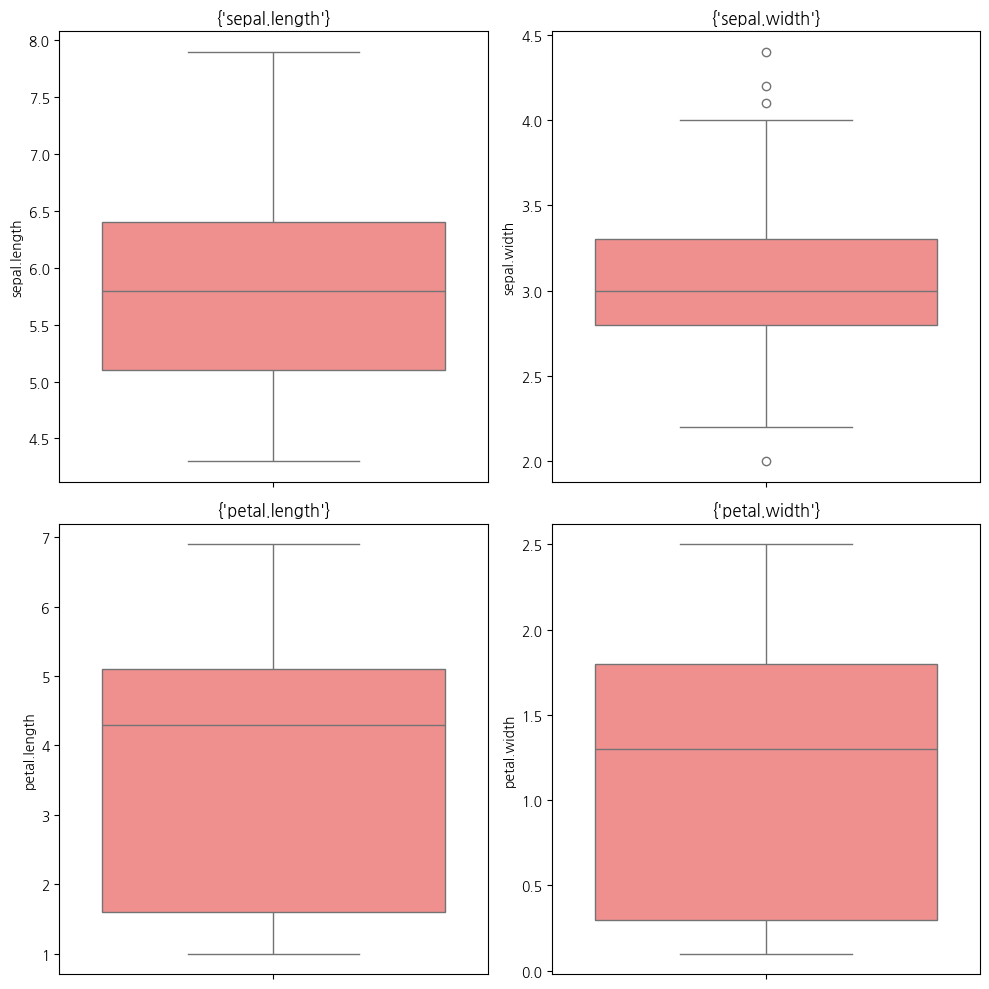

In [29]:
# ==================================================================
# [2-2] 결측치, 이상치, 중복값 확인
# ==================================================================
print(dataDF.isnull().sum(), '\n')

print(dataDF.duplicated().sum(), '\n')
dataDF.drop_duplicates(inplace=True)


numeric_columns = dataDF.select_dtypes(include = [np.number]).columns

print("====== [이상치 확인 및 처리] ======")
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_columns):
    
    sns.boxplot(data=dataDF, y=col, ax=axes[idx], palette='spring')
    axes[idx].set_title({col})
    plt.tight_layout()
    
for col in numeric_columns:
    Q1 = dataDF[col].quantile(0.25)
    Q3 = dataDF[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier = dataDF[(dataDF[col] < lower) | (dataDF[col] > upper)]
    print(f"이상치 처리 전 {col} : {len(outlier)}")

    dataDF = dataDF[(dataDF[col] >= lower) & (dataDF[col] <= upper)]
    outlier_delete = dataDF[(dataDF[col] < lower) | (dataDF[col] > upper)]
    print(f"이상치 처리 후 {col} : {len(outlier_delete)}\n")

[3] 피쳐와 타겟 분리 <hr>

In [30]:
targetSR = dataDF['variety']
print(f"targetSR  : {targetSR.ndim}, {targetSR.shape}")

featureDF = dataDF.iloc[:, :-1]
print(f"featureDF : {featureDF.ndim}, {featureDF.shape}")

targetSR  : 1, (145,)
featureDF : 2, (145, 4)


[4] 학습용, 테스트용 데이터셋 분리 <hr>

In [31]:
x_train, x_test, y_train, y_test = train_test_split(
    featureDF,
    targetSR,
    test_size=0.2,
    stratify=targetSR
)

print(f"{x_train.shape}, {y_test.shape}")

(116, 4), (29,)


[5] all_estimator <hr>

In [32]:
estimators = all_estimators(type_filter='classifier')
print(len(estimators))

44


In [35]:
results = []

for name, estimatorClass in estimators:

    try:
        model = estimatorClass()
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)             # 타겟 예측
        accuracy = accuracy_score(y_test, y_pred)  # test 타겟과 예측 타겟 비교
        
        results.append({
            'model': name,
            'accuracy': accuracy,
            'class':estimatorClass
        })
        print(f"{name}: {accuracy:.4f}")

    except:
        print(f"{name}: 실패")
        # continue

resultDF = pd.DataFrame(results).sort_values('accuracy', ascending=(False))
print(resultDF[['model', 'accuracy']].head())

bestModelClass = resultDF.iloc[0]['class']
print(bestModelClass)

AdaBoostClassifier: 0.9310
BaggingClassifier: 0.9655
BernoulliNB: 0.3448
CalibratedClassifierCV: 0.9655
CategoricalNB: 0.9310
ClassifierChain: 실패
ComplementNB: 0.6552
DecisionTreeClassifier: 0.9655
DummyClassifier: 0.3448
ExtraTreeClassifier: 0.8621
ExtraTreesClassifier: 0.9655
FixedThresholdClassifier: 실패
GaussianNB: 1.0000
GaussianProcessClassifier: 0.9655
GradientBoostingClassifier: 0.9655
HistGradientBoostingClassifier: 0.9310
KNeighborsClassifier: 0.9655
LabelPropagation: 0.9655
LabelSpreading: 0.9655
LinearDiscriminantAnalysis: 1.0000
LinearSVC: 0.9655
LogisticRegression: 1.0000
LogisticRegressionCV: 1.0000
MLPClassifier: 0.9655
MultiOutputClassifier: 실패
MultinomialNB: 0.9310
NearestCentroid: 0.9310
NuSVC: 0.9655
OneVsOneClassifier: 실패
OneVsRestClassifier: 실패
OutputCodeClassifier: 실패
PassiveAggressiveClassifier: 0.7586
Perceptron: 0.5517
QuadraticDiscriminantAnalysis: 1.0000
RadiusNeighborsClassifier: 0.9655
RandomForestClassifier: 1.0000
RidgeClassifier: 0.8621
RidgeClassifierCV

[6] Pipeline 구축 <hr>

In [ ]:
best_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", bestModelClass())
])

bestModel = best_pipeline.fit(x_train, y_train)

bestModel.score(x_test, y_test)

print(class)

1.0